In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X = pd.read_csv('secom.data', sep=r'\s+', header=None)
y = pd.read_csv('secom_labels.data', sep=r'\s+', header=None, usecols=[0])
y = y.values.ravel()
unique_vals = np.unique(y[~np.isnan(y)])

In [6]:
if -1 in unique_vals and 1 in unique_vals:
    y = (y == 1).astype(int)

In [7]:
initial_cols = X.shape[1]
X_var = X.var()
constant_cols = X_var[X_var == 0].index.tolist()
X = X.drop(columns=constant_cols)

In [8]:
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")

Missing values after imputation: 0


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)
print(f"Data standardized. Mean: {X_scaled.mean().mean():.6f}, Std: {X_scaled.std().mean():.6f}")

Data standardized. Mean: -0.000000, Std: 1.000319


In [10]:
start_time = time.time()
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
mi_ranking = np.argsort(mi_scores)[::-1]
mi_top20 = mi_ranking[:20]
mi_time = time.time() - start_time
print(f"Top 20 features selected using MI")
print(f"Execution time: {mi_time:.4f} seconds")
print(f"Top 5 MI scores: {mi_scores[mi_top20[:5]]}")

Top 20 features selected using MI
Execution time: 2.3662 seconds
Top 5 MI scores: [0.02807592 0.0267149  0.02654343 0.02601716 0.02530736]


In [11]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf, n_features_to_select=20, step=10)
rfe.fit(X_scaled, y)
rfe_selected = np.where(rfe.support_)[0]
rfe_time = time.time() - start_time
print(f"Top 20 features selected using RFE")
print(f"Execution time: {rfe_time:.4f} seconds")

Top 20 features selected using RFE
Execution time: 16.7327 seconds


In [12]:
start_time = time.time()
U, sigma, Vt = np.linalg.svd(X_scaled.values, full_matrices=False)
print(f"SVD completed: U{U.shape}, Σ{sigma.shape}, V^T{Vt.shape}")
print(f"Top 5 singular values: {sigma[:5]}")

SVD completed: U(1567, 474), Σ(474,), V^T(474, 474)
Top 5 singular values: [203.18719336 164.47398762 144.81841994 137.46760859 127.55632808]


In [13]:
k = 20
V = Vt.T

svd_scores = np.zeros(X_scaled.shape[1])
for j in range(X_scaled.shape[1]):
    score = 0
    for i in range(k):
        score += (sigma[i] ** 2) * np.abs(V[j, i])
    svd_scores[j] = score

svd_ranking = np.argsort(svd_scores)[::-1]
svd_top20 = svd_ranking[:20]
svd_time = time.time() - start_time
print(f"Top 20 features selected using SVD scoring")
print(f"Execution time: {svd_time:.4f} seconds")
print(f"Top 5 SVD scores: {svd_scores[svd_top20[:5]]}")

Top 20 features selected using SVD scoring
Execution time: 1.8326 seconds
Top 5 SVD scores: [14723.59127707 14723.59127707 14723.59127707 14723.59127707
 14723.59127707]


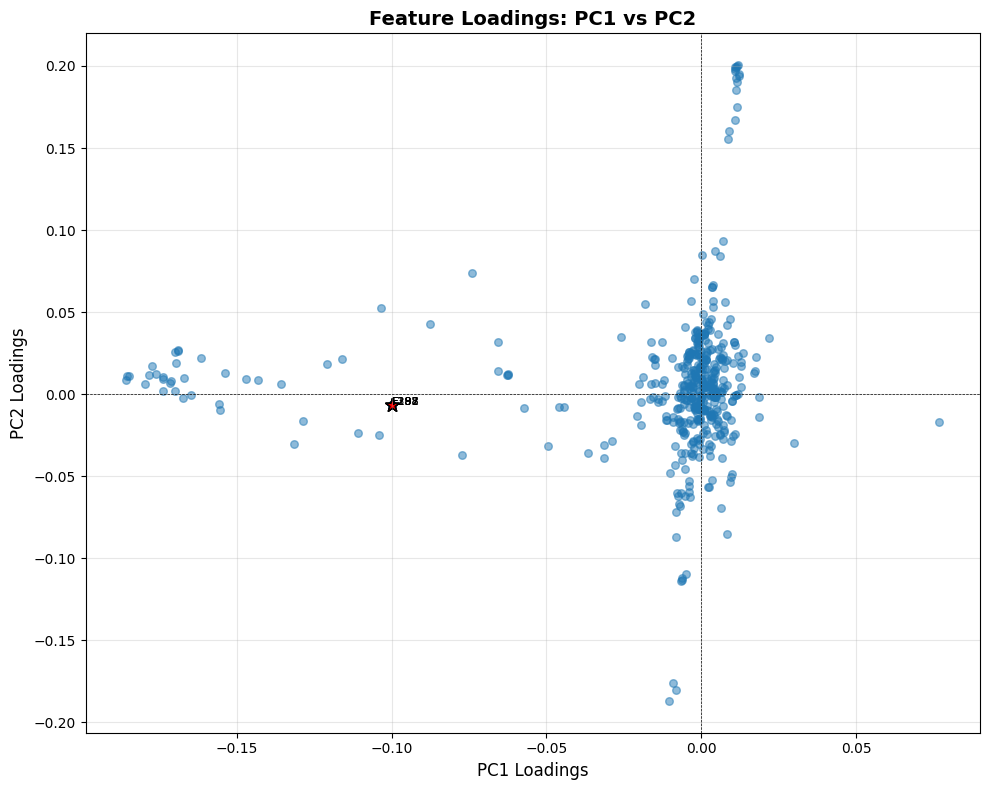

In [14]:
fig1 = plt.figure(figsize=(10, 8))

plt.scatter(V[:, 0], V[:, 1], alpha=0.5, s=30)
plt.xlabel('PC1 Loadings', fontsize=12)
plt.ylabel('PC2 Loadings', fontsize=12)
plt.title('Feature Loadings: PC1 vs PC2', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

for idx in svd_top20[:5]:
    plt.scatter(V[idx, 0], V[idx, 1], c='red', s=100, marker='*', 
               edgecolors='black', linewidth=1)
    plt.annotate(f'F{idx}', (V[idx, 0], V[idx, 1]), fontsize=8)

plt.tight_layout()
plt.savefig('plot1_loadings.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
noise_level = 0.05
X_noisy = X_scaled.values + np.random.randn(*X_scaled.shape) * noise_level * X_scaled.std().mean()

In [16]:
U_n, sigma_n, Vt_n = np.linalg.svd(X_noisy, full_matrices=False)
V_n = Vt_n.T
svd_scores_noisy = np.zeros(X_scaled.shape[1])
for j in range(X_scaled.shape[1]):
    score = 0
    for i in range(k):
        score += (sigma_n[i] ** 2) * np.abs(V_n[j, i])
    svd_scores_noisy[j] = score
svd_top20_noisy = np.argsort(svd_scores_noisy)[::-1][:20]

In [17]:
mi_scores_noisy = mutual_info_classif(X_noisy, y, random_state=42)
mi_top20_noisy = np.argsort(mi_scores_noisy)[::-1][:20]

In [18]:
rfe_noisy = RFE(estimator=rf, n_features_to_select=20, step=10)
rfe_noisy.fit(X_noisy, y)
rfe_selected_noisy = np.where(rfe_noisy.support_)[0]

In [19]:
svd_stability = len(set(svd_top20) & set(svd_top20_noisy)) / 20 * 100
mi_stability = len(set(mi_top20) & set(mi_top20_noisy)) / 20 * 100
rfe_stability = len(set(rfe_selected) & set(rfe_selected_noisy)) / 20 * 100

print(f"\nStability Results (% overlap after 5% noise):")
print(f"  SVD Method: {svd_stability:.1f}%")
print(f"  MI Method:  {mi_stability:.1f}%")
print(f"  RFE Method: {rfe_stability:.1f}%")


Stability Results (% overlap after 5% noise):
  SVD Method: 100.0%
  MI Method:  30.0%
  RFE Method: 55.0%


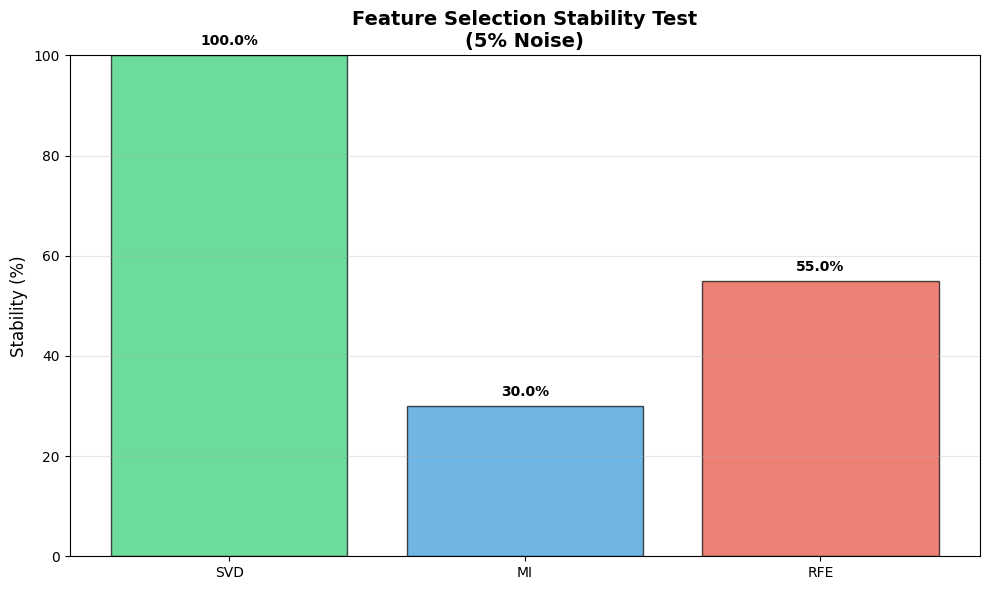

In [20]:
fig2 = plt.figure(figsize=(10, 6))
methods = ['SVD', 'MI', 'RFE']
stabilities = [svd_stability, mi_stability, rfe_stability]
colors = ['#2ecc71', '#3498db', '#e74c3c']
plt.bar(methods, stabilities, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Stability (%)', fontsize=12)
plt.title('Feature Selection Stability Test\n(5% Noise)', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(stabilities):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('plot2_stability.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled.values, y, test_size=0.3, random_state=42, stratify=y
)

results = []

In [22]:
X_train_mi = X_train[:, mi_top20]
X_test_mi = X_test[:, mi_top20]
lr_mi = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_mi.fit(X_train_mi, y_train)
y_pred_mi = lr_mi.predict(X_test_mi)
acc_mi = accuracy_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)
results.append(['MI', acc_mi, f1_mi, mi_time])
print(f"  MI Method - Accuracy: {acc_mi:.4f}, F1-Score: {f1_mi:.4f}")

  MI Method - Accuracy: 0.6518, F1-Score: 0.1717


In [23]:
X_train_rfe = X_train[:, rfe_selected]
X_test_rfe = X_test[:, rfe_selected]
lr_rfe = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = lr_rfe.predict(X_test_rfe)
acc_rfe = accuracy_score(y_test, y_pred_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
results.append(['RFE', acc_rfe, f1_rfe, rfe_time])
print(f"  RFE Method - Accuracy: {acc_rfe:.4f}, F1-Score: {f1_rfe:.4f}")

  RFE Method - Accuracy: 0.7495, F1-Score: 0.2892


In [24]:
X_train_svd = X_train[:, svd_top20]
X_test_svd = X_test[:, svd_top20]
lr_svd = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_svd.fit(X_train_svd, y_train)
y_pred_svd = lr_svd.predict(X_test_svd)
acc_svd = accuracy_score(y_test, y_pred_svd)
f1_svd = f1_score(y_test, y_pred_svd)
results.append(['SVD', acc_svd, f1_svd, svd_time])
print(f"  SVD Method - Accuracy: {acc_svd:.4f}, F1-Score: {f1_svd:.4f}")

  SVD Method - Accuracy: 0.5924, F1-Score: 0.1351


In [25]:
df_results = pd.DataFrame(results, columns=['Method', 'Accuracy', 'F1-Score', 'Time (s)'])
print("\n" + "=" * 60)
print("COMPARISON TABLE")
print("=" * 60)
print(df_results.to_string(index=False))
print("=" * 60)


COMPARISON TABLE
Method  Accuracy  F1-Score  Time (s)
    MI  0.651805  0.171717  2.366198
   RFE  0.749469  0.289157 16.732717
   SVD  0.592357  0.135135  1.832578


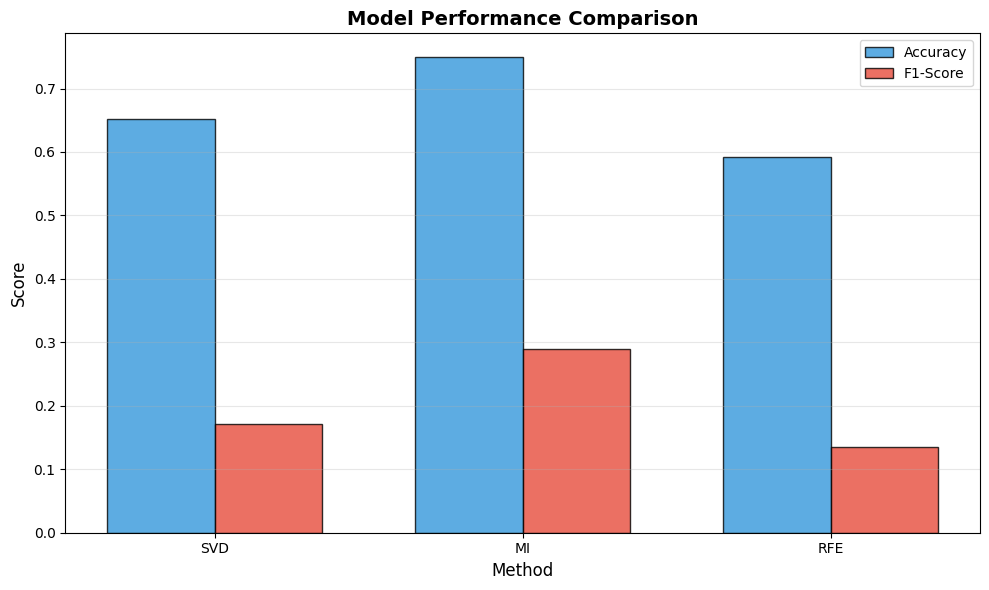

In [26]:
fig3 = plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.35
plt.bar(x - width/2, df_results['Accuracy'], width, label='Accuracy', 
        color='#3498db', alpha=0.8, edgecolor='black')
plt.bar(x + width/2, df_results['F1-Score'], width, label='F1-Score', 
        color='#e74c3c', alpha=0.8, edgecolor='black')
plt.xlabel('Method', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, methods)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plot3_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [27]:
mi_set = set(mi_top20)
rfe_set = set(rfe_selected)
svd_set = set(svd_top20)

mi_rfe = len(mi_set & rfe_set)
mi_svd = len(mi_set & svd_set)
rfe_svd = len(rfe_set & svd_set)
all_three = len(mi_set & rfe_set & svd_set)

print(f"  MI ∩ RFE: {mi_rfe} features ({mi_rfe/20*100:.1f}%)")
print(f"  MI ∩ SVD: {mi_svd} features ({mi_svd/20*100:.1f}%)")
print(f"  RFE ∩ SVD: {rfe_svd} features ({rfe_svd/20*100:.1f}%)")
print(f"  MI ∩ RFE ∩ SVD: {all_three} features ({all_three/20*100:.1f}%)")

  MI ∩ RFE: 2 features (10.0%)
  MI ∩ SVD: 1 features (5.0%)
  RFE ∩ SVD: 1 features (5.0%)
  MI ∩ RFE ∩ SVD: 0 features (0.0%)


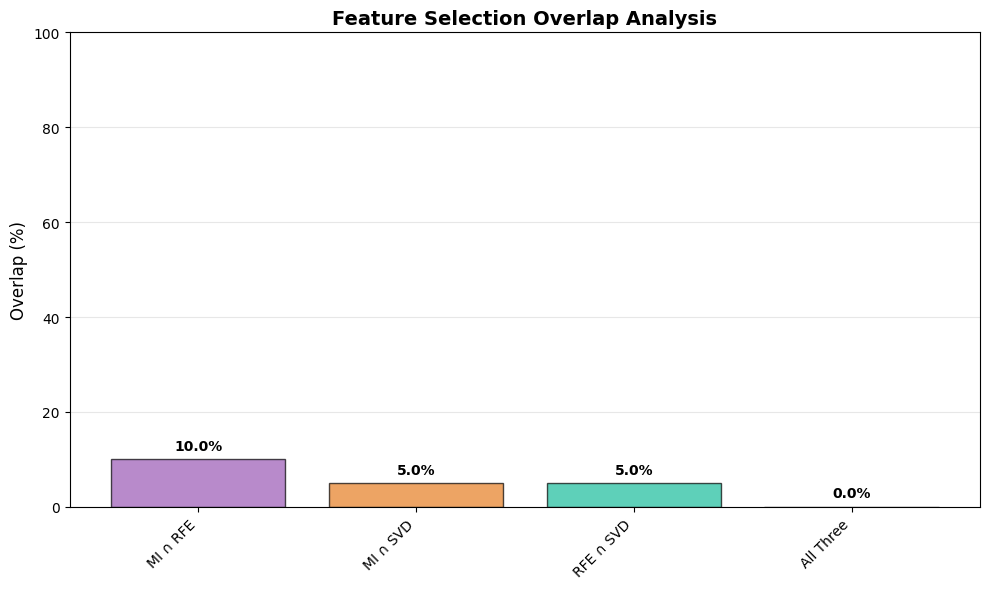

In [28]:
fig4 = plt.figure(figsize=(10, 6))
overlap_data = [
    ['MI ∩ RFE', mi_rfe/20*100],
    ['MI ∩ SVD', mi_svd/20*100],
    ['RFE ∩ SVD', rfe_svd/20*100],
    ['All Three', all_three/20*100]
]
labels = [x[0] for x in overlap_data]
values = [x[1] for x in overlap_data]
colors_overlap = ['#9b59b6', '#e67e22', '#1abc9c', '#34495e']
plt.bar(labels, values, color=colors_overlap, alpha=0.7, edgecolor='black')
plt.ylabel('Overlap (%)', fontsize=12)
plt.title('Feature Selection Overlap Analysis', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(values):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('plot4_overlap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()